<a href="https://colab.research.google.com/github/wcarvalho/jaxneurorl/blob/main/Visualizing_Successor_Representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helper functions

In [ ]:
# @title gridworld definition

import enum
import random
import numpy as np
import numpy.ma as ma


GOAL = 3
FLOOR = 0
WALL = 1
AGENT = 2


class Gridworld:
  def __init__(self, width, height, wall_length, agent_position=None):
    self.width = width
    self.height = height
    self.wall_length = wall_length
    self.grid = self.create_grid(agent_position)

  def create_grid(self, agent_position=None):
    # Initialize the grid with empty spaces
    grid = np.zeros((self.height, self.width), dtype=np.int32)

    # Add the walls around the grid
    for i in range(self.width):
      grid[0, i] = 1
      grid[self.height - 1, i] = WALL

    for i in range(self.height):
      grid[i, 0] = 1
      grid[i, self.width - 1] = WALL

    # Add the wall in the middle
    wall_start = (self.width - self.wall_length) // 2
    self.wall_row = self.height // 2
    for i in range(wall_start, wall_start + self.wall_length):
      grid[self.wall_row, i] = WALL

    # Place the goal
    grid[1, self.width - 2] = GOAL
    self.goal_position = (1, self.width - 2)

    # Place the agent
    self.set_agent(grid, agent_position)
    self.get_states(grid)

    return grid

  def get_states(self, grid):
    # Count valid states and assign a unique ID to each
    state_to_id = {}
    id_to_state = {}
    for i in range(self.height):
      for j in range(self.width):
        if grid[i, j] != 1:
          idx = len(state_to_id)
          state_to_id[(i, j)] = idx
          id_to_state[idx] = (i, j)

    num_states = len(state_to_id)
    self.state_to_id = state_to_id
    self.id_to_state = id_to_state
    self.num_states = num_states

  def set_agent(self, grid=None, agent_position=None):
    if agent_position is None:
      while True:
        x = np.random.randint(1, self.width - 2)
        y = np.random.randint(1, self.height - 2)
        if grid[y, x] == 0:
          grid[y, x] = AGENT
          self.agent_position = (y, x)
          break
    else:
      y, x = agent_position
      at_grid = grid[y, x]
      if at_grid != FLOOR:
        print(grid)

        raise RuntimeError(
          f"Trying to place agent at {agent_position} but {at_grid} present"
        )
      grid[y, x] = AGENT
      self.agent_position = agent_position

  def reset(self, agent_position=None):
    self.grid = self.create_grid(agent_position=agent_position)
    return self.agent_position

  def step(self, action):
    y, x = self.agent_position
    if action == "up":
      y -= 1
    elif action == "down":
      y += 1
    elif action == "left":
      x -= 1
    elif action == "right":
      x += 1

    if self.grid[y, x] in {0, 3}:
      self.grid[self.agent_position[0], self.agent_position[1]] = 0
      self.agent_position = (y, x)
      self.grid[y, x] = 2

    done = (y, x) == self.goal_position
    reward = -0.1
    if done:
      reward = 1
    return self.agent_position, reward, done

  def current_state(self):
    return self.state_to_id[self.agent_position]

  def get_rewards(self):
    # Initialize rewards vector with -1
    rewards = -0.1 * np.ones(self.num_states)

    # Set goal state reward to 1
    goal_state_id = self.state_to_id[self.goal_position]
    rewards[goal_state_id] = 1

    return rewards

  def print_grid(self):
    print(self.grid)


# # Usage example
# gw = Gridworld(7, 7, 3, agent_position=(4,3))
# gw.print_grid()

In [ ]:
# @title visualize gridworld

import matplotlib.pyplot as plt
import numpy as np


def hex_to_rgb(hex_color):
  hex_color = hex_color.lstrip("#")
  return list(int(hex_color[i : i + 2], 16) / 255 for i in (0, 2, 4))


def state_to_label(state_id):
  return f"$s_{{{state_id + 1}}}$"


def visualize_gridworld(gw, ax=None, visualize_ids=False):
  gridworld = gw.grid
  # Define the color map
  color_map = {
    FLOOR: [1, 1, 1],  # white
    WALL: hex_to_rgb("666666"),  # grey
    GOAL: hex_to_rgb("2DA858"),  # green
    AGENT: hex_to_rgb("E06666"),  # red
  }

  # Create an empty grid with RGB channels
  visualization = np.zeros((len(gridworld), len(gridworld[0]), 3))

  # Assign colors based on the gridworld
  for i in range(len(gridworld)):
    for j in range(len(gridworld[0])):
      visualization[i, j] = color_map[gridworld[i][j]]

  # Create the plot
  if ax is None:
    _, ax = plt.subplots()
  ax.imshow(visualization)

  # Place the text for free spaces, agent and goal positions
  if visualize_ids:
    for i in range(len(gridworld)):
      for j in range(len(gridworld[0])):
        if gridworld[i, j] != WALL:  # only for free spaces, agent, and goal
          state_id = gw.state_to_id[(i, j)]
          ax.text(
            j,
            i,
            state_to_label(state_id),
            ha="center",
            va="center",
            color="b",
          )

  ax.axis("off")  # Turn off axis


# # Usage example
# gw2 = Gridworld(7, 7, 3, agent_position=(4,1))
# visualize_gridworld(gw2, visualize_ids=True)

In [ ]:
# @title visualize gridworld with reward

from matplotlib import colors


def visualize_rewards(gridworld, rewards, cmap="Purples", ax=None, norm=None):
  """Overlay the gridworld visualization with a heatmap of rewards."""

  # Create empty grid
  reward_grid = np.zeros(gridworld.grid.shape)

  # For each reward, get the corresponding position on grid and put value there
  for pos, state_id in gridworld.state_to_id.items():
    y, x = pos
    reward_grid[y, x] = rewards[state_id]

  reward_grid_masked = ma.masked_where(gridworld.grid != FLOOR, reward_grid)

  # Visualize gridworld
  if ax is None:
    _, ax = plt.subplots()

  visualize_gridworld(gridworld, ax=ax)

  # Overlay grid with reward heatmap using a colormap with alpha channel
  if norm is None:
    norm = colors.Normalize(vmin=-1, vmax=1)

  im = ax.imshow(
    reward_grid_masked, cmap=cmap, alpha=0.5, interpolation="nearest", norm=norm
  )

  # Add reward text
  for i in range(gridworld.height):
    for j in range(gridworld.width):
      if gridworld.grid[i, j] != WALL:  # add numbers anywhere there isn't a wall
        state_id = gridworld.state_to_id[(i, j)]
        ax.text(
          j,
          i,
          f"{rewards[state_id]:.2f}",
          ha="center",
          va="center",
          color="w",
        )

  return ax, reward_grid_masked, im


# # Visualize the reward heatmap
# rewards = gw.get_rewards()
# _ = visualize_rewards(gw, rewards)

In [ ]:
# @title simulate trajectories

import jax


# Random Policy
def random_policy(env):
  return random.choice(["up", "down", "left", "right"])


# Optimal Policy
def optimal_policy(env):
  y, x = env.agent_position
  goal_y, goal_x = env.goal_position

  if y == env.wall_row:
    return "up"
  elif y > env.wall_row:  # bottom half
    if x < goal_x:
      return "right"
    elif y > goal_y:
      return "up"
  else:  # top half
    if y > goal_y:
      return "up"
    elif x < goal_x:
      return "right"
  return None  # goal reached, no more moves


def simulate_trajectories(
  env,
  policy,
  agent_position=None,
  num_trajectories=100,
  max_length=15,
  visualize=False,
):
  # Count valid states and assign a unique ID to each
  if visualize:
    num_trajectories = 1
    # fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax = None

  def vis(env):
    visualize_gridworld(env, ax)
    plt.show()
    # plt.pause(0.25)  # pause for a while
    # plt.draw()  # necessary for dynamic plots

  def onehot(x):
    return jax.nn.one_hot(x, num_classes=env.num_states)

  trajectories = []
  for _ in range(num_trajectories):
    state = env.reset(agent_position=agent_position)
    if visualize:
      vis(env)
    trajectory = []
    trajectory.append(onehot(env.current_state()))
    for t in range(max_length):
      action = policy(env)
      if action is None:  # goal reached, no more moves
        break
      agent_pos, reward, done = env.step(action)

      trajectory.append(onehot(env.current_state()))
      if visualize:
        vis(env)

      if done:
        break
    trajectories.append(np.array(trajectory))

  return trajectories


# # Example usage
# agent_position=(4, 2)
# gw = Gridworld(7, 7, 3, agent_position=agent_position)

# trajectories = simulate_trajectories(gw, optimal_policy, agent_position=agent_position, num_trajectories=100, max_length=50, visualize=True)

# Compute and visualize the successor representation

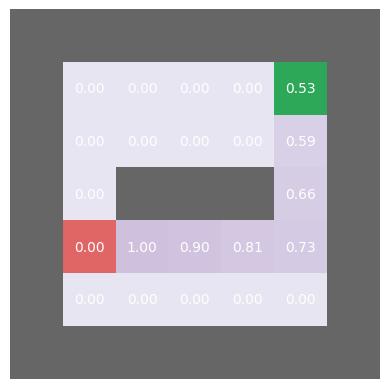

In [ ]:
# @title compute & visualize SR


def compute_SR(trajectory, gamma=0.99):
  # VERY DUMB AND SLOW FUNCTION
  num_states = trajectories[0].shape[-1]
  M = np.zeros((num_states, num_states))
  for t in range(len(trajectory) - 1):
    # Get current start_state
    one_hot = trajectory[t]
    start_state = np.argmax(one_hot)

    # Iterate over future time steps
    for t_future in range(t + 1, len(trajectory)):
      other_state = np.argmax(trajectory[t_future])

      # Calculate discounted future occupancy and add to M
      exp = t_future - t - 1
      M[start_state, other_state] += gamma**exp

  return M


def compute_average_SR(trajectories, gamma=0.9):
  # Iterate over all trajectories
  SRs = []
  for trajectory in trajectories:
    computed_sr = compute_SR(trajectory, gamma=gamma)

    SRs.append(computed_sr)
  M_avg = np.array(SRs).mean(0)

  return M_avg


def visualize_pairwise_SR(
  sr_matrix,
  gridworld,
  rewards=None,
  cmap="Purples",
  start_pos=None,
  ax=None,
  norm=None,
):
  """Given a start state position, plot the SR row for that position (i.e. SR starting from that state).
  This is overlaid on the gridworld.
  """
  # Create empty grid
  sr_grid = np.zeros(gridworld.grid.shape)

  # get state_id for start position
  start_pos = start_pos or gridworld.agent_position
  start_pos_state_id = gridworld.state_to_id[start_pos]

  # sr for all next states given start position
  sr_from_pos = sr_matrix[start_pos_state_id]

  # for each sr, get the corresponding position on grid and put value there
  for next_state_id, sr in enumerate(sr_from_pos):
    y, x = gridworld.id_to_state[next_state_id]
    sr_grid[y, x] = sr

  sr_grid_masked = ma.masked_where(gridworld.grid != FLOOR, sr_grid)

  # Visualize gridworld
  if ax is None:
    _, ax = plt.subplots()

  visualize_gridworld(gridworld, ax=ax)

  # Overlay grid with SR heatmap using a colormap with alpha channel
  if norm is None:
    norm = colors.Normalize(vmin=-1, vmax=1)

  im = ax.imshow(
    sr_grid_masked, cmap=cmap, alpha=0.25, interpolation="nearest", norm=norm
  )

  # Add value text
  for i in range(gridworld.height):
    for j in range(gridworld.width):
      if gridworld.grid[i, j] != WALL:  # add numbers anywhere there isn't a wall
        state_id = gridworld.state_to_id[(i, j)]
        ax.text(
          j,
          i,
          f"{sr_from_pos[state_id]:.2f}",
          ha="center",
          va="center",
          color="w",
        )

  return ax, sr_grid_masked, im


# Usage Example
agent_position = (4, 1)
gw = Gridworld(7, 7, 3, agent_position=agent_position)

trajectories = simulate_trajectories(
  gw,
  optimal_policy,
  agent_position=agent_position,
  num_trajectories=1,
  max_length=50,
  visualize=False,
)
M = compute_average_SR(trajectories)

# reset agent position for visualization
gw.reset(agent_position=agent_position)
_ = visualize_pairwise_SR(M, gw)

In [ ]:
# @title compute & visualize V(s)

import numpy.ma as ma


def visualize_pairwise_SR_value(
  sr_matrix, gridworld, rewards=None, cmap="winter", ax=None, norm=None
):
  # Create empty grid
  value_grid = np.zeros(gridworld.grid.shape)

  if rewards is None:
    rewards = gridworld.get_rewards()

  for pos, state_id in gridworld.state_to_id.items():
    y, x = pos
    sr_from_pos = sr_matrix[state_id]
    # Calculate value
    value = (sr_from_pos * rewards).sum()
    value_grid[y, x] = value

  value_grid_masked = ma.masked_where(gridworld.grid != FLOOR, value_grid)

  # Visualize gridworld
  if ax is None:
    _, ax = plt.subplots()

  visualize_gridworld(gridworld, ax=ax)

  # Overlay grid with value heatmap using a colormap with alpha channel
  if norm is None:
    norm = colors.Normalize(vmin=-1, vmax=1)

  im = ax.imshow(
    value_grid_masked, cmap=cmap, alpha=0.5, interpolation="nearest", norm=norm
  )

  # Place the text for free spaces, agent and goal positions
  for i in range(gridworld.height):
    for j in range(gridworld.width):
      if gridworld.grid[i, j] != WALL:  # only for free spaces, agent, and goal
        state_id = gridworld.state_to_id[(i, j)]
        ax.text(j, i, f"{value_grid[i, j]:.2f}", ha="center", va="center", color="w")

  return ax, value_grid_masked, im


# # Usage Example
# agent_position=(4, 1)
# gw = Gridworld(7, 7, 3, agent_position=agent_position)

# trajectories = simulate_trajectories(gw, optimal_policy, agent_position=agent_position, num_trajectories=1, max_length=50, visualize=False)
# gw.reset(agent_position=agent_position)
# M = compute_average_SR(trajectories)
# _ = visualize_pairwise_SR_value(M, gw, rewards=gw.get_rewards())

# Create Plots for Figure 2

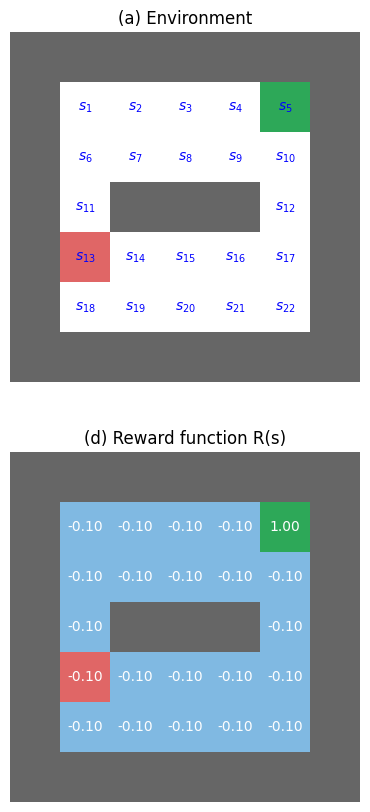

In [ ]:
# @title Environment + Reward

agent_position = (4, 1)
gw = Gridworld(7, 7, 3, agent_position=agent_position)


fig, axs = plt.subplots(2, 1, figsize=(5, 10))

# Visualizing SR for random policy
visualize_gridworld(gw, ax=axs[0], visualize_ids=True)
axs[0].set_title("(a) Environment")

# Visualizing Reward function
gw.reset(agent_position)
visualize_rewards(gw, ax=axs[1], rewards=gw.get_rewards(), cmap="winter")
axs[1].set_title("(d) Reward function R(s)")
plt.show()

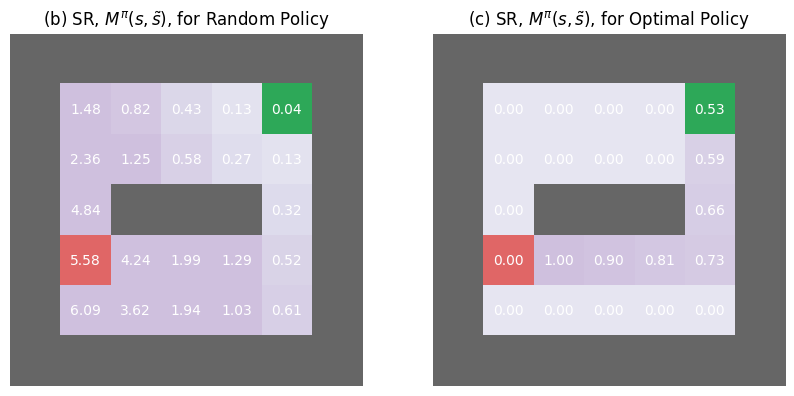

In [ ]:
# @title SR for Random Policy vs. Optimal Policy

agent_position = (4, 1)
gw = Gridworld(7, 7, 3, agent_position=agent_position)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Visualizing SR for random policy
trajectories = simulate_trajectories(
  gw,
  random_policy,
  agent_position=agent_position,
  num_trajectories=100,
  max_length=40,
  visualize=False,
)
M = compute_average_SR(trajectories)
gw.reset(agent_position)
visualize_pairwise_SR(M, gw, ax=axs[0])
axs[0].set_title("(b) SR, $M^{\\pi}(s, \\tilde{s})$, for Random Policy")

# Visualizing SR for optimal policy
trajectories = simulate_trajectories(
  gw,
  optimal_policy,
  agent_position=agent_position,
  num_trajectories=100,
  max_length=40,
  visualize=False,
)
M = compute_average_SR(trajectories)
gw.reset(agent_position)
visualize_pairwise_SR(M, gw, ax=axs[1])
axs[1].set_title("(c) SR, $M^{\\pi}(s, \\tilde{s})$, for Optimal Policy")

plt.show()

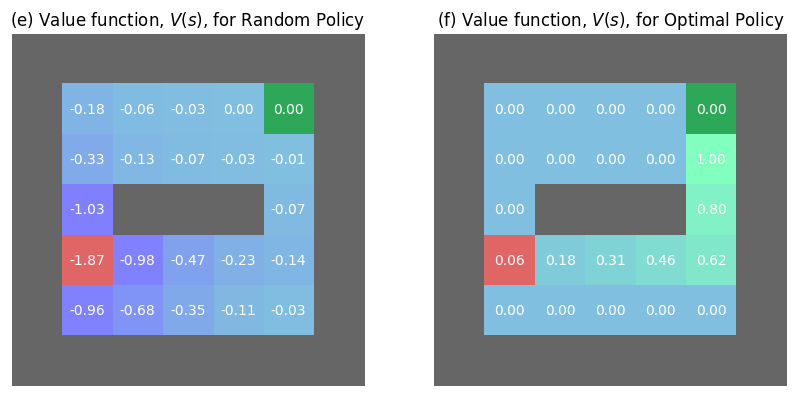

In [ ]:
# @title Value for Random Policy vs. Optimal Policy

agent_position = (4, 1)
gw = Gridworld(7, 7, 3, agent_position=agent_position)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Visualizing SR for random policy
trajectories = simulate_trajectories(
  gw,
  random_policy,
  agent_position=agent_position,
  num_trajectories=100,
  max_length=15,
  visualize=False,
)
M = compute_average_SR(trajectories)
gw.reset(agent_position)
visualize_pairwise_SR_value(M, gw, ax=axs[0])
axs[0].set_title("(e) Value function, $V(s)$, for Random Policy")

# Visualizing SR for optimal policy
trajectories = simulate_trajectories(
  gw,
  optimal_policy,
  agent_position=agent_position,
  num_trajectories=100,
  max_length=15,
  visualize=False,
)
M = compute_average_SR(trajectories)
gw.reset(agent_position)
visualize_pairwise_SR_value(M, gw, ax=axs[1])
axs[1].set_title("(f) Value function, $V(s)$, for Optimal Policy")

plt.show()